## Offline RL

In [1]:
# HIDDEN
import gym
import numpy as np

#### Is this realistic?

- So far we've built a simulation of user behavior
- In some applications, we may be able to build accurate simulations:
  - physics simulations (e.g. robots)
  - games
  - economic/financial simulations?
- However, for user behavior, this is hard

#### Is this realistic? 

- Best would be to deploy RL live, but not practical
- Another possibility: learn from user data?
- We can do this with **offline reinforcement learning**

#### Offline RL

- What is offline RL?
- Recall our RL loop:

![](img/RL-loop-3.png)

#### Offline RL

- In offline RL we don't have an environment to interact with in a feedback loop:

![](img/offline-RL-loop.png)

This historic data was generated by some other, unknown policy/policies.

Notes:

Could be generate by real users, or by a different source (random, or RL agent!)

#### Challenge of offline RL

- Can't answer "what if" questions
- We can only see the results of actions attempted in the dataset

Notes:

Perhaps this makes us appreciate how valuable/awesome it is to actually have an env available, which we have had for all the rest of the course. It allows us to try anything with no cost except computational cost (assuming it's a simulator, not a real world environment). 

In [2]:
# HIDDEN
# #### Types of offline RL

# Two main categories:

# 1. No rewards available: try to _imitate_ historic policy

# This boils down to supervised learning of observations -> actions
 
# 2. Rewards available: try to _improve upon_ historic policy

# Use rewards to improve policy. This is what we want, ideally!

#### Recommender dataset

- Let's explore an offline dataset that we can learn from.
- We'll need a bit of code to read all the JSON objects in the file:

Notes:

The file is in the format that RLlib learns from.

In [3]:
import json

json_dataset_file = "data/recommender_offline.json"

rollouts = []
with open(json_dataset_file, "r") as f:
    for line in f:
        data = json.loads(line)
        rollouts.append(data)

In [4]:
len(rollouts)

50

We have 50 "rollouts" of data.

#### Recommender dataset

Each rollout is a dict containing info about the time step:

In [5]:
from ray.rllib.utils.compression import unpack, pack

obs = unpack(rollouts[0]["obs"])
obs.shape

(200, 2)

- We have 200 time steps worth of data in each rollout
- Each is an observation:

Notes:

This number 200 is set by the "rollout_fragment_length" algorithm config parameter.

In [6]:
obs[:3]

array([[0.6545137 , 0.29728338],
       [0.5238871 , 0.5144319 ],
       [0.6741674 , 0.10163702]], dtype=float32)

- Here are the first 3 observations
- We can see `num_candidates` was set as 2

#### Recommender dataset

We can also look at the first 3 actions, rewards, dones:

In [7]:
rollouts[0]["actions"][:3]

[0, 0, 1]

In [8]:
rollouts[0]["rewards"][:3]

[0.6545137166976929, 0.3524414300918579, 0.05838315561413765]

In [9]:
rollouts[0]["dones"][:3]

[False, False, False]

Notes:

So, first the agent saw the observation [0.65, 0.297] from the previous slide, then it took action 0, got a reward of 0.65, and the episode was not done.

There is more information stored in the dataset than just the above, but these are the key points.

#### Offline RL training

- Lots of info on offline RL with RLlib [here](https://docs.ray.io/en/latest/rllib/rllib-offline.html)
- First we need our trainer config.

In [10]:
num_candidates = 2

offline_trainer_config = {
    # These should look familiar:
    "framework"             : "torch",
    "create_env_on_driver"  : True,
    "seed"                  : 0,
    "model"                 : {
        "fcnet_hiddens"     : [64, 64]
    },
    
    # These are new for offline RL:
    "input": [json_dataset_file],
    "observation_space": gym.spaces.Box(low=0, high=1, shape=(num_candidates,)),
    "action_space": gym.spaces.Discrete(num_candidates),
}

Notes:

- The config items on the top should look familiar. On the second half, things are a bit different:
  - We need to give it the path to the dataset file
  - Because there is no env, we need to manually specify the observation and action spaces
- We don't have an environment config because there is no environment!

#### Training

- For offline RL we can't use `PPO`.
- We'll use the `MARWIL` algorithm that is included with RLlib.

In [11]:
from ray.rllib.agents.marwil import MARWILTrainer

In [12]:
trainer = MARWILTrainer(config=offline_trainer_config)

In [13]:
for i in range(10):
    trainer.train()

Ok, we apparently did some training. _How do we evaluate without a simulator?_

#### Offline evaluation

In [18]:
trainer.evaluate()["evaluation"]["off_policy_estimator"]["wis"]

{'V_prev': 16.325394203305805,
 'V_step_WIS': 22.619529016166922,
 'V_gain_est': 1.3817053996773574}

- Recall that we achieved rewards of >25 last time
- But this may be the best we can do with the given data

Notes:

- V_prev shows the estimated episode reward of the historical policy
- V_step_WIS shows the estimate episode reward of the new policy
- V_gain_est is the ratio of these two quantities; here we see an estimated improvement of 38%.

#### Ground-truth evaluation

- We can also evaluate the algorithm using our env simulator:

In [22]:
# HIDDEN
from envs import BasicRecommender

env_config = {
    "num_candidates" : 2,
    "alpha"          : 0.5,
    "seed"           : 42
}

In [27]:
env = BasicRecommender(env_config)

def get_episode_reward(env, trainer):
    obs = env.reset()
    done = False
    total_reward = 0
    while not done:
        action = trainer.compute_single_action(obs)
        obs, reward, done, _ = env.step(action)
        total_reward += reward
    return total_reward

In [28]:
np.mean([get_episode_reward(env, trainer) for i in range(100)])

25.490920840544344

Notes:

In a real offline RL situation where all we had is the user data, we wouldn't have an accurate simulator available. We're just using it here as a sanity check to see if our MARWIL algorithm learned effectively. 

It is also possible to have RLlib do this for you by setting `"input_evaluation": ["simulation"]` and providing the env. However, then we have to trust it not to use the env for learning!

#### Let's apply what we learned!

## When to use offline RL?
<!-- multiple choice -->

#### Which of the following situations is an example of offline RL?

- [ ] Teaching an AI to play chess by having it play against other AIs repeatedly.
- [x] Teaching an AI to play chess based on past games by professional chess players.

#### If you have a simulator available, does it make sense to use offline RL techniques?

- [ ] Yes, offline RL methods are more effective than traditional RL methods.
- [ ] No, RL methods should never be used if a simulator is available.
- [x] Maybe, if high-quality historical data is available and the simulator is a highly flawed representation of reality. | Note that it is also possibly to mix a simulator with historical data.

## Historical data policy
<!-- multiple choice -->

Offline RL relies on data generated by some policy interacting with the environment. Which of the following is **NOT** a desirable property of this dataset / historical policy?
 
- [x] The environment and the historical policy are both deterministic. | In this case, we would only explore one trajectory through the environment. 
- [ ] The dataset contains a large number of episodes.
- [ ] The historical policy explores a variety of states in the environment.
- [ ] The historical policy achieves high reward in some episodes.   

## Coding
<!-- coding exercise -->

In this exercise we'll tackle the famous [Cartpole benchmark problem](https://www.gymlibrary.ml/environments/classic_control/cart_pole/) that is bundled with the `gym` library. The goal is to keep the inverted pendulum from falling over by applying force, either left or right, at each time step. 

talk about evaluation using the simulator

/Users/mike/miniconda3/envs/rl-course-dev-2/lib/python3.8/site-packages/gym/spaces/box.py:73: UserWarning: WARN: Box bound precision lowered by casting to float32
  logger.warn(
2022-07-15 11:15:05,348	WARNING rollout_worker.py:664 -- Requested 'simulation' input evaluation method: will discard all sampler outputs and keep only metrics.


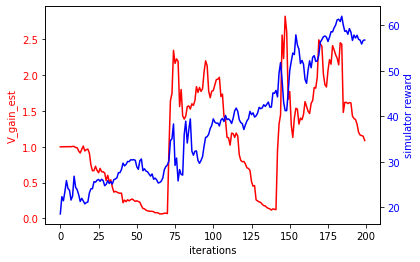

In [53]:
# SOLUTION
import gym
import numpy as np
import matplotlib.pyplot as plt
from ray.rllib.agents.marwil import MARWILTrainer

offline_trainer_config = {
    # These should look familiar:
    "framework"             : "torch",
    "create_env_on_driver"  : True,
    "seed"                  : 0,
    "model"                 : {
        "fcnet_hiddens"     : [64, 64]
    },
    
    # These are new for offline RL:
    "input": ["data/cartpolev1_offline.json"],
    "observation_space": gym.spaces.Box(low=np.array([-4.8, -np.inf, -0.42, -np.inf]), 
                                        high=np.array([4.8,  np.inf,  0.42,  np.inf])),
    "action_space": gym.spaces.Discrete(2),
    "input_evaluation" : ["simulation", "is", "wis"],
    "env" : "CartPole-v1" # for evaluation only
}

trainer = MARWILTrainer(config=offline_trainer_config)

results_off = []
results_sim = []
for i in range(200):
    r = trainer.train()
    results_off.append(r["off_policy_estimator"]["wis"]['V_gain_est'])
    results_sim.append(r["episode_reward_mean"])

fig, ax1 = plt.subplots() 
ax1.set_xlabel('iterations') 
ax1.set_ylabel('V_gain_est', color='r') 
ax1.plot(results_off, color='r') 
ax1.tick_params(axis ='y', labelcolor='red') 
ax2 = ax1.twinx() 
ax2.set_ylabel('simulator reward', color='b') 
ax2.plot(results_sim, color='b') 
ax2.tick_params(axis ='y', labelcolor='blue') 

trainer.stop()

In [ ]:
# SOLUTION